In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchOptics.optics as tt
import torchOptics.metrics as tm
import warnings
import torchvision.transforms as transforms
import time
import torchvision
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

meta = {'wl' : (515e-9), 'dx':(7.56e-6, 7.56e-6)}
warnings.filterwarnings('ignore')

pixel_pitch = 7.56e-6
rmeta = {'wl': (638e-9), 'dx': (pixel_pitch, pixel_pitch)}
gmeta = {'wl': (515e-9), 'dx': (pixel_pitch, pixel_pitch)}
bmeta = {'wl': (450e-9), 'dx': (pixel_pitch, pixel_pitch)}
metas = [rmeta, gmeta, bmeta]

target = tt.imread("0877.png", meta=meta)
crop = transforms.CenterCrop(1024-128)
crop_target = transforms.CenterCrop(1024-128)(target)

g_target = target[0].unsqueeze(0).unsqueeze(0)

In [1]:
import torchOptics.optics as tt
import warnings
import torch.nn as nn
import torchOptics.metrics as tm
import torch.nn.functional as F
import torch.optim
import torch
from torch.utils.data import Dataset, DataLoader
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torchvision
import datetime
import tqdm
import time
import pandas as pd
import HHS.model


warnings.filterwarnings('ignore')


class SignFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, th):
        ctx.save_for_backward(input)
        t = torch.Tensor([th]).to(input.device)  # threshold
        output = (input > t).float() * 1
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output * torch.ones_like(input)  # Replace with your custom gradient computation
        return grad_input

class RealSign(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        output = torch.sign(input)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output * torch.ones_like(input)  # Replace with your custom gradient computation
        return grad_input


class Dataset512(Dataset):
    def __init__(self, target_dir, meta, transform=None, isTrain=True, padding=0):
        self.target_dir = target_dir
        self.transform = transform
        self.meta = meta
        self.isTrain = isTrain
        self.target_list = sorted(glob.glob(target_dir+'*.png'))
        self.center_crop = torchvision.transforms.CenterCrop(1024)
        self.random_crop = torchvision.transforms.RandomCrop((1024, 1024))
        self.padding = padding

    def __len__(self):
        return len(self.target_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        target = tt.imread(self.target_list[idx], meta=meta)
        if target.shape[-1] < 1024 or target.shape[-2] < 1024:
            target = torchvision.transforms.Resize(1024)(target)
        if self.isTrain:
            target = self.random_crop(target)
            target = torchvision.transforms.functional.pad(target, (self.padding, self.padding, self.padding, self.padding))
        else:
            target = self.center_crop(target)
            target = torchvision.transforms.functional.pad(target, (self.padding, self.padding, self.padding, self.padding))
        return target


def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

# load data
batch_size = 1
target_dir = 'dataset/DIV2K/DIV2K_train_HR/'
valid_dir = 'dataset/DIV2K/DIV2K_valid_HR/'
# sim_dir = 'binary_dataset/simulated/'
meta = {'wl' : (638e-9, 515e-9, 450e-9), 'dx':(7.56e-6, 7.56e-6)}
padding = 0
train_dataset = Dataset512(target_dir=target_dir, meta=meta, isTrain=True, padding=padding)
valid_dataset = Dataset512(target_dir=valid_dir, meta=meta, isTrain=False, padding=padding)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)


def train(model, num_hologram=10, custom_name='fcn', epochs=100, lr=1e-4, z=2e-3):
    date = datetime.datetime.now() - datetime.timedelta(hours=15)
    mean_psnr_list = []
    mean_mse_list = []
    max_epoch = 0
    max_psnr = 0
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    sign_function = SignFunction.apply
    # path = 'models/'
    model_name = f'{date}_{custom_name}_{num_hologram}_{z}'
    # make result folder
    result_folder = 'result/'+model_name
    os.mkdir(result_folder)
    model_path = os.path.join(result_folder, model_name)
    psnr_result_path = os.path.join(result_folder, 'meanPSNR.npy')
    mse_result_path = os.path.join(result_folder, 'meanMSE.npy')
    result = {'model_path': model_path, 'psnr_result_path': psnr_result_path,
          'mse_result_path': mse_result_path, 'z': z,
          'num_hologram': num_hologram, 'lr': lr, 'epochs': epochs}
    # save result dict
    with open(os.path.join(result_folder, 'result_dict.pickle'), 'wb') as fw:
        pickle.dump(result, fw)
    for epoch in range(epochs):
        pbar = tqdm.tqdm(trainloader)
        model.train()
        for target in pbar:
            out = model(target)
            binary = sign_function(out)
            sim = tt.simulate(binary, z).abs()**2
            result = torch.mean(sim, dim=1, keepdim=True)
            loss = tt.relativeLoss(result, target, F.mse_loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            psnrList = []
            mseList = []
            for valid in validloader:
                out = model(valid)
                binary = sign_function(out)
                sim = tt.simulate(binary, z).abs()**2
                result = torch.mean(sim, dim=1, keepdim=True)
                psnr = tt.relativeLoss(result, valid, tm.get_PSNR)
                psnrList.append(psnr)
                mse = tt.relativeLoss(result, valid, F.mse_loss).detach().cpu().numpy()
                mseList.append(mse)
            mean_psnr = sum(psnrList)/len(psnrList)
            mean_mse = sum(mseList)/len(mseList)
            mean_psnr_list.append(mean_psnr)
            mean_mse_list.append(mean_mse)
            # save psnr and mse
            np.save(psnr_result_path, mean_psnr_list)
            np.save(mse_result_path, mean_mse_list)
            plt.plot(np.arange(len(mean_psnr_list)), mean_psnr_list,
                     label=f'max psnr: {max(mean_psnr_list)}')
            plt.title(model_name+'_psnr')
            plt.legend()
            plt.savefig(os.path.join(result_folder, 'meanPSNR.png'))
            plt.clf()
            plt.plot(np.arange(len(mean_mse_list)), mean_mse_list,
                     label=f'max psnr: {min(mean_mse_list)}')
            plt.title(model_name+'_mse')
            plt.legend()
            plt.savefig(os.path.join(result_folder, 'meanMSE.png'))
            plt.clf()
            print(f'mean PSNR : {mean_psnr} {epoch}/{epochs}')
            print(f'mean MSE : {mean_mse} {epoch}/{epochs}')

        if mean_psnr > max_psnr:
            max_psnr = mean_psnr
            max_epoch = epoch
            torch.save(model.state_dict(), model_path)
        print(f'max_psnr: {max_psnr}, epoch: {max_epoch}')


def binary_sim(out, z=2e-3):
    binary = SignFunction.apply(out)
    sim = tt.simulate(binary, z).abs()**2
    res = torch.mean(sim, dim=1, keepdim=True)
    return binary, res


def valid(model):
    with torch.no_grad():
        psnr_list = []
        for target in validloader:
            out = model(target)
            binary, res = binary_sim(out)
            psnr = tt.relativeLoss(res, target, tm.get_PSNR)
            psnr_list.append(psnr)
    print(sum(psnr_list)/len(psnr_list))


def check_order(bmodel, classifier, target):
    if len(target.shape) == 3:
        target = target.unsqueeze(0)
    result = []
    with torch.no_grad():
        out = bmodel(target)
        binary, res = binary_sim(out)
        for i in range(10):
            binary_input = binary[0][i].unsqueeze(0).unsqueeze(0)
            prop_order = classifier(binary_input)
            result.append(torch.argmax(prop_order))
    print(result)


def check_order_without_model(binary, classifier):
    with torch.no_grad():
        result = []
        for i in range(10):
            binary_input = binary[0][i].unsqueeze(0).unsqueeze(0)
            prop_order = classifier(binary_input)
            result.append(torch.argmax(prop_order))
    print(result)


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc = nn.Linear(64 * 64 * 64, 10)  # 최종 분류를 위한 FC 레이어

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = x.view(-1, 64 * 64 * 64)  # flatten
        x = self.fc(x)
        return x


def rgb_binary_sim(out, z, th):
    pixel_pitch = 7.56e-6
    meta = {'wl' : (638e-9, 515e-9, 450e-9), 'dx':(pixel_pitch, pixel_pitch)}
    rmeta = {'wl': (638e-9), 'dx': (pixel_pitch, pixel_pitch)}
    gmeta = {'wl': (515e-9), 'dx': (pixel_pitch, pixel_pitch)}
    bmeta = {'wl': (450e-9), 'dx': (pixel_pitch, pixel_pitch)}
    sign = SignFunction.apply
    binary = sign(out, th)
    channel = out.shape[1]
    rchannel = int(channel/3)
    gchannel = int(channel*2/3)
    red = binary[:, :rchannel, :, :]
    green = binary[:, rchannel:gchannel, :, :]
    blue = binary[:, gchannel:, :, :]
    red = tt.Tensor(red, meta=rmeta)
    green = tt.Tensor(green, meta=gmeta)
    blue = tt.Tensor(blue, meta=bmeta)
    rsim = tt.simulate(red, z).abs()**2
    gsim = tt.simulate(green, z).abs()**2
    bsim = tt.simulate(blue, z).abs()**2
    rmean = torch.mean(rsim, dim=1, keepdim=True)
    gmean = torch.mean(gsim, dim=1, keepdim=True)
    bmean = torch.mean(bsim, dim=1, keepdim=True)
    rgb = torch.cat([rmean, gmean, bmean], dim=1)
    rgb = tt.Tensor(rgb, meta=meta)
    binary = tt.Tensor(binary, meta=meta)
    return binary, rgb

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [2]:
class BinaryNet(nn.Module):
    def __init__(self, num_hologram, final='Sigmoid', in_planes=3,
                 channels=[32, 64, 128, 256, 512, 1024, 2048, 4096],
                 convReLU=True, convBN=True, poolReLU=True, poolBN=True,
                 deconvReLU=True, deconvBN=True):
        super(BinaryNet, self).__init__()

        def CRB2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True, relu=True, bn=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            if relu:
                layers += [nn.Tanh()]
            if bn:
                layers += [nn.BatchNorm2d(num_features=out_channels)]

            cbr = nn.Sequential(*layers) # *으로 list unpacking 

            return cbr

        def TRB2d(in_channels, out_channels, kernel_size=2, stride=2, bias=True, relu=True, bn=True):
            layers = []
            layers += [nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels,
                                          kernel_size=2, stride=2, padding=0,
                                          bias=True)]
            if bn:
                layers += [nn.BatchNorm2d(num_features=out_channels)]
            if relu:
                layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers) # *으로 list unpacking 

            return cbr

        self.enc1_1 = CRB2d(3, channels[0], relu=convReLU, bn=convBN)
        self.enc1_2 = CRB2d(channels[0], channels[0], relu=convReLU, bn=convBN)
        self.pool1 = CRB2d(channels[0], channels[0], stride=2, relu=poolReLU, bn=poolBN)

        self.enc2_1 = CRB2d(channels[0], channels[1], relu=convReLU, bn=convBN)
        self.enc2_2 = CRB2d(channels[1], channels[1], relu=convReLU, bn=convBN)
        self.pool2 = CRB2d(channels[1], channels[1], stride=2, relu=poolReLU, bn=poolBN)

        self.enc3_1 = CRB2d(channels[1], channels[2], relu=convReLU, bn=convBN)
        self.enc3_2 = CRB2d(channels[2], channels[2], relu=convReLU, bn=convBN)
        self.pool3 = CRB2d(channels[2], channels[2], stride=2, relu=poolReLU, bn=poolBN)

        self.enc4_1 = CRB2d(channels[2], channels[3], relu=convReLU, bn=convBN)
        self.enc4_2 = CRB2d(channels[3], channels[3], relu=convReLU, bn=convBN)
        self.pool4 = CRB2d(channels[3], channels[3], stride=2, relu=poolReLU, bn=poolBN)

        self.enc5_1 = CRB2d(channels[3], channels[4], relu=convReLU, bn=convBN)
        self.enc5_2 = CRB2d(channels[4], channels[4], relu=convReLU, bn=convBN)

        self.deconv4 = TRB2d(channels[4], channels[3], relu=deconvReLU, bn=deconvBN, stride=2)
        self.dec4_1 = CRB2d(channels[4], channels[3], relu=convReLU, bn=convBN)
        self.dec4_2 = CRB2d(channels[3], channels[3], relu=convReLU, bn=convBN)

        self.deconv3 = TRB2d(channels[3], channels[2], relu=deconvReLU, bn=deconvBN, stride=2)
        self.dec3_1 = CRB2d(channels[3], channels[2], relu=convReLU, bn=convBN)
        self.dec3_2 = CRB2d(channels[2], channels[2], relu=convReLU, bn=convBN)

        self.deconv2 = TRB2d(channels[2], channels[1], relu=deconvReLU, bn=deconvBN, stride=2)
        self.dec2_1 = CRB2d(channels[2], channels[1], relu=convReLU, bn=convBN)
        self.dec2_2 = CRB2d(channels[1], channels[1], relu=convReLU, bn=convBN)

        self.deconv1 = TRB2d(channels[1], channels[0], relu=deconvReLU, bn=deconvBN, stride=2)
        self.dec1_1 = CRB2d(channels[1], channels[0], relu=convReLU, bn=convBN)
        self.dec1_2 = CRB2d(channels[0], channels[0], relu=convReLU, bn=convBN)

        self.classifier = CRB2d(channels[0], num_hologram, relu=False, bn=False)

    def forward(self, x):
        # Encoder
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)
        enc5_2 = self.enc5_2(enc5_1)

        deconv4 = self.deconv4(enc5_2)
        concat4 = torch.cat((deconv4, enc4_2), dim=1)
        dec4_1 = self.dec4_1(concat4)
        dec4_2 = self.dec4_2(dec4_1)

        deconv3 = self.deconv3(dec4_2)
        concat3 = torch.cat((deconv3, enc3_2), dim=1)
        dec3_1 = self.dec3_1(concat3)
        dec3_2 = self.dec3_2(dec3_1)

        deconv2 = self.deconv2(dec3_2)
        concat2 = torch.cat((deconv2, enc2_2), dim=1)
        dec2_1 = self.dec2_1(concat2)
        dec2_2 = self.dec2_2(dec2_1)

        deconv1 = self.deconv1(dec2_2)
        concat1 = torch.cat((deconv1, enc1_2), dim=1)
        dec1_1 = self.dec1_1(concat1)
        dec1_2 = self.dec1_2(dec1_1)

        # Final classifier
        out = self.classifier(dec1_2)
        out = nn.Sigmoid()(out)
        return out


model = BinaryNet(num_hologram=24, in_planes=3, convReLU=False,
                  convBN=False, poolReLU=False, poolBN=False,
                  deconvReLU=False, deconvBN=False).cuda()
test = torch.randn(1, 3, 512, 512).cuda()
out = model(test)
print(out.shape)

torch.Size([1, 24, 512, 512])


In [3]:
model.load_state_dict(torch.load('result/2024-10-17 14:27:01.569309_1018_proposed_7.56e-6_24_0.002/2024-10-17 14:27:01.569309_1018_proposed_7.56e-6_24_0.002'))
print('')

In [4]:
# sim = np.asarray(Image.open('binary hologram/simulated/241115/76_1.bmp'))
# sim = tt.Tensor(sim, meta=gmeta).unsqueeze(0).unsqueeze(0)/255
# max_psnr = 0
# for y in range(180, 220):
#     for x in range(520, 560):
#         for w in range(3210, 3250):
#             crop_sim = sim[:, :, y:y+w,x:x+w]
#             flip_sim = torch.flip(crop_sim, dims=[2])
#             resize_sim = torchvision.transforms.Resize((1024,1024))(flip_sim)
#             psnr = tt.relativeLoss(crop(resize_sim), crop(g_target), tm.get_PSNR)
#             if max_psnr < psnr:
#                 max_psnr = psnr
#                 x_max = x
#                 y_max = y
#                 w_max = w
# crop_sim = mean_sim[:, :, y_max:y_max+w_max,x_max:x_max+w_max]
# flip_sim = torch.flip(crop_sim, dims=[2])
# resize_sim = torchvision.transforms.Resize((1024,1024))(flip_sim)
# tt.show_with_insets(crop(resize_sim), crop(g_target))


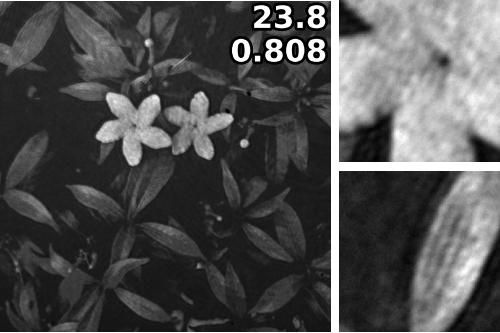

In [72]:
target = tt.imread("0877.png", meta=meta)
crop = transforms.CenterCrop(1024-128)
crop_target = transforms.CenterCrop(1024-128)(target)
g_target = target[0].unsqueeze(0).unsqueeze(0)
sim = np.asarray(Image.open('binary hologram/simulated/241115/76_725.bmp'))
sim = tt.Tensor(sim, meta=gmeta).unsqueeze(0).unsqueeze(0)/255
crop_sim = sim[:, :, y_max:y_max+w_max,x_max:x_max+w_max]
flip_sim = torch.flip(crop_sim, dims=[2])
resize_sim = torchvision.transforms.Resize((1024,1024))(flip_sim)
tt.show_with_insets(crop(resize_sim), crop(g_target))


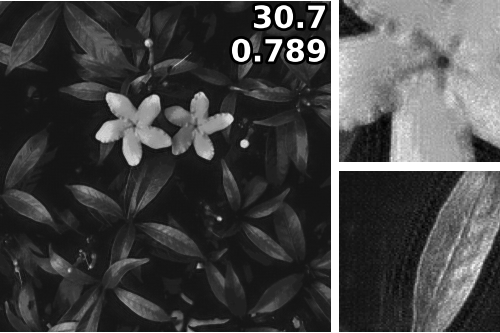

In [8]:
idx = 76
target = valid_dataset[idx].unsqueeze(0)
crop = torchvision.transforms.CenterCrop(1024-128)
out = model(target)
binary, sim = rgb_binary_sim(out, 2e-3, 0.5)
g_target = target[0][1].unsqueeze(0).unsqueeze(0)
g_sim = sim[0][1].unsqueeze(0).unsqueeze(0)
tt.show_with_insets(crop(g_sim), crop(g_target))


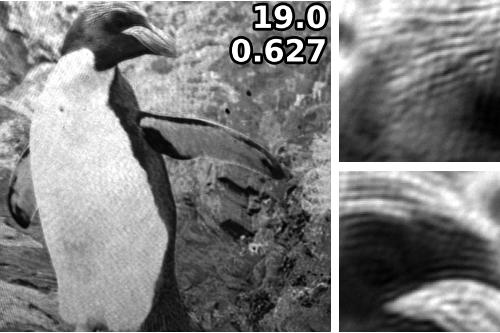

In [73]:
target = tt.imread("0801.png", meta=meta)
crop = transforms.CenterCrop(1024-128)
crop_target = transforms.CenterCrop(1024-128)(target)
g_target = target[0].unsqueeze(0).unsqueeze(0)
sim = np.asarray(Image.open('binary hologram/simulated/241115/0_725.bmp'))
sim = tt.Tensor(sim, meta=gmeta).unsqueeze(0).unsqueeze(0)/255
crop_sim = sim[:, :, y_max:y_max+w_max,x_max:x_max+w_max]
flip_sim = torch.flip(crop_sim, dims=[2])
resize_sim = torchvision.transforms.Resize((1024,1024))(flip_sim)
tt.show_with_insets(crop(resize_sim), crop(g_target))


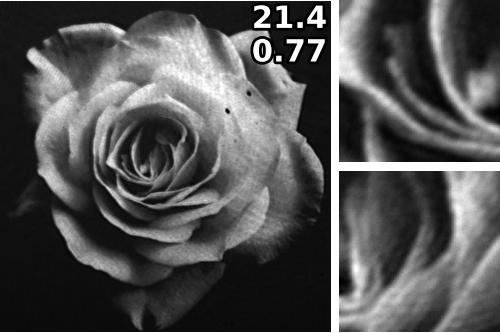

In [75]:
target = tt.imread("0843.png", meta=meta)
crop = transforms.CenterCrop(1024-128)
crop_target = transforms.CenterCrop(1024-128)(target)
g_target = target[0].unsqueeze(0).unsqueeze(0)
sim = np.asarray(Image.open('binary hologram/simulated/241115/42_725.bmp'))
sim = tt.Tensor(sim, meta=gmeta).unsqueeze(0).unsqueeze(0)/255
crop_sim = sim[:, :, y_max:y_max+w_max,x_max:x_max+w_max]
flip_sim = torch.flip(crop_sim, dims=[2])
resize_sim = torchvision.transforms.Resize((1024,1024))(flip_sim)
tt.show_with_insets(crop(resize_sim), crop(g_target))


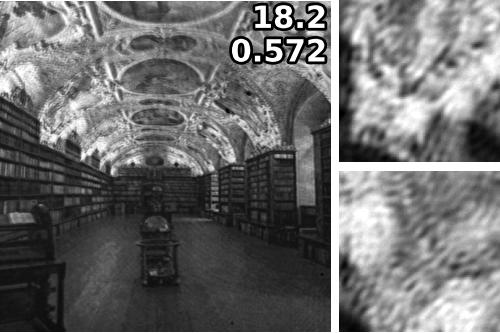

In [78]:
target = tt.imread("0841.png", meta=meta)
crop = transforms.CenterCrop(1024-128)
crop_target = transforms.CenterCrop(1024-128)(target)
g_target = target[0].unsqueeze(0).unsqueeze(0)
sim = np.asarray(Image.open('binary hologram/simulated/241115/40_725.bmp'))
sim = tt.Tensor(sim, meta=gmeta).unsqueeze(0).unsqueeze(0)/255
crop_sim = sim[:, :, y_max:y_max+w_max,x_max:x_max+w_max]
flip_sim = torch.flip(crop_sim, dims=[2])
resize_sim = torchvision.transforms.Resize((1024,1024))(flip_sim)
tt.show_with_insets(crop(resize_sim), crop(g_target))


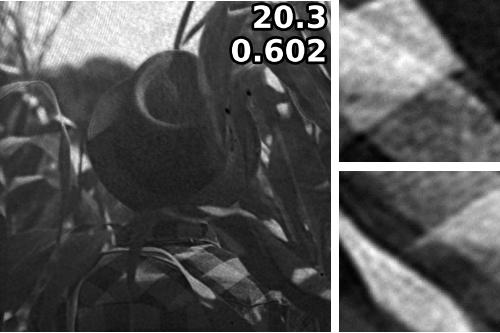

In [76]:
target = tt.imread("0893.png", meta=meta)
crop = transforms.CenterCrop(1024-128)
crop_target = transforms.CenterCrop(1024-128)(target)
g_target = target[0].unsqueeze(0).unsqueeze(0)
sim = np.asarray(Image.open('binary hologram/simulated/241115/92_725.bmp'))
sim = tt.Tensor(sim, meta=gmeta).unsqueeze(0).unsqueeze(0)/255
crop_sim = sim[:, :, y_max:y_max+w_max,x_max:x_max+w_max]
flip_sim = torch.flip(crop_sim, dims=[2])
resize_sim = torchvision.transforms.Resize((1024,1024))(flip_sim)
tt.show_with_insets(crop(resize_sim), crop(g_target))

In [56]:
x_max, y_max, w_max, max_psnr

(541, 206, 3227, 23.48910903930664)

In [ ]:
crop_sim = sim[:,:,193:3420,537:3764]

In [53]:
3764-537

3227


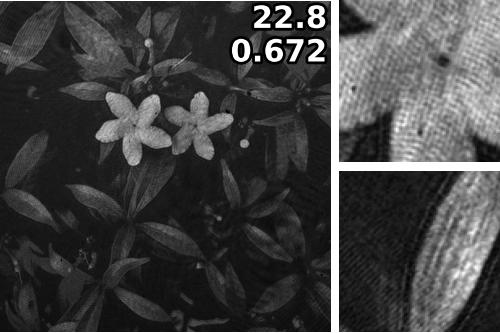

In [67]:
crop_sim = sim[:, :, y_max:y_max+w_max,x_max:x_max+w_max]
flip_sim = torch.flip(crop_sim, dims=[2])
resize_sim = torchvision.transforms.Resize((1024,1024))(flip_sim)
tt.show_with_insets(crop(resize_sim), crop(g_target))

In [68]:
x_max, y_max, w_max, max_psnr

(950, 175, 3230, 22.7999324798584)

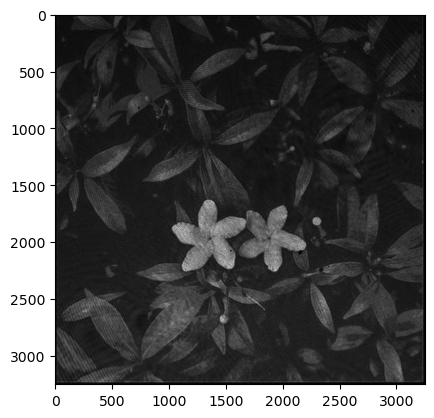

{'wl': 5.15e-07, 'dx': (7.56e-06, 7.56e-06)}

In [49]:
y = 165
x = 940
w = 3250
sim[:, :, y:y+w,x:x+w]

In [34]:
np.arange(0, 10, 5)

array([0, 5])

In [47]:
max_psnr = 0
for y in np.arange(120, 180, 5):
    for x in np.arange(915, 955, 5):
        crop_sim = sim[:, :, y:y+w,x:x+w]
        flip_sim = torch.flip(crop_sim, dims=[2])
        resize_sim = torchvision.transforms.Resize((1024,1024))(flip_sim)
        psnr = tt.relativeLoss(crop(resize_sim), crop(g_target), tm.get_PSNR)
        if max_psnr < psnr:
            max_psnr = psnr
            x_max = x
            y_max = y

In [48]:
x_max, y_max, max_psnr

(940, 165, 22.381269454956055)


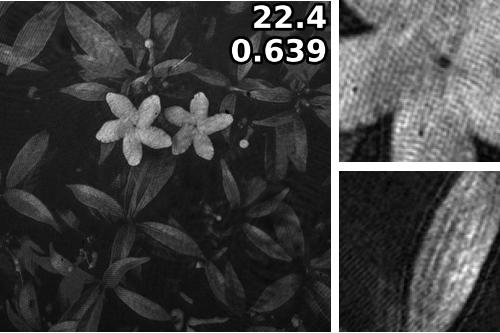

In [50]:
crop_sim = sim[:, :, y_max:y_max+w,x_max:x_max+w]
flip_sim = torch.flip(crop_sim, dims=[2])
resize_sim = torchvision.transforms.Resize((1024,1024))(flip_sim)
tt.show_with_insets(crop(resize_sim), crop(g_target))


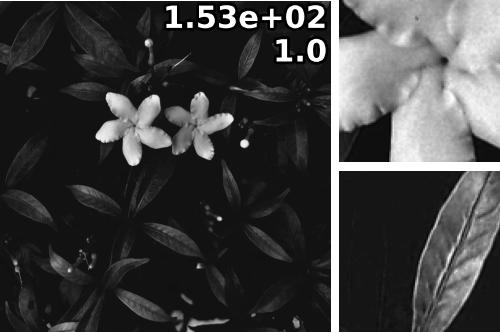

In [18]:
tt.show_with_insets(crop(g_target), crop(g_target), correct_colorwise=True)

In [79]:
tt.relativeLoss(crop(resize_sim), crop(g_target), tm.get_PSNR)

21.945837020874023


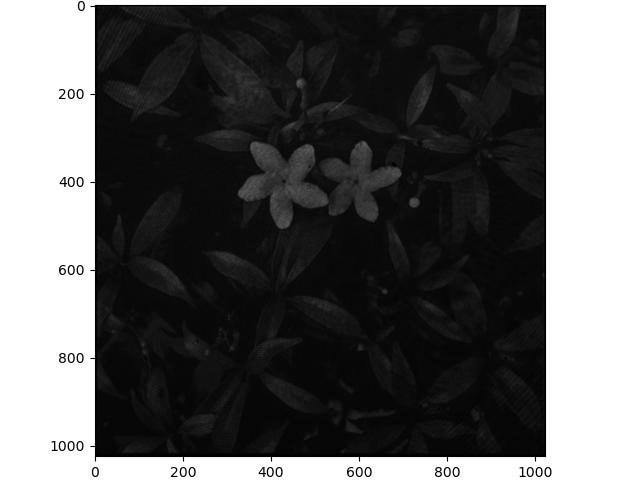

In [87]:
sim = tt.Tensor([], meta=meta)
colors = ['red', 'green', 'blue']
for i in range(8):
    sim_each_color = np.asarray(Image.open(f'simulated/241105_2/g_{i}.bmp'))
    sim_each_color = tt.Tensor(sim_each_color, gmeta).unsqueeze(0).unsqueeze(0)
    if sim.shape[0] == 0:
        sim = sim_each_color
    else:
        sim = torch.cat([sim, sim_each_color], dim=1)
sim = sim/255
mean_sim = torch.mean(sim, dim=1).unsqueeze(0)
crop_sim = mean_sim[:, :, 170:3420,925:925+3250]
flip_sim = torch.flip(crop_sim, dims=[2])
resize_sim = torchvision.transforms.Resize((1024,1024))(flip_sim)
tt.show(resize_sim)


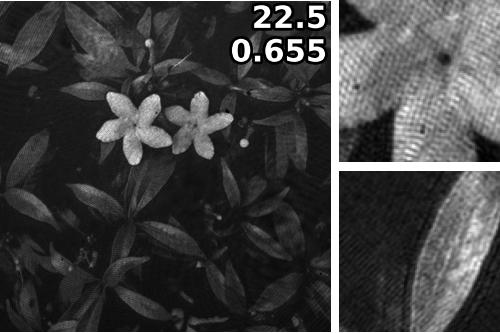

In [88]:
tt.show_with_insets(crop(resize_sim), crop(g_target), correct_colorwise=True)

In [51]:
# sim = tt.Tensor([], meta=meta)
# colors = ['red', 'green', 'blue']
# for i in range(8):
#     sim_each_color = np.asarray(Image.open(f'simulated/241102/g_{i}.bmp'))
#     sim_each_color = tt.Tensor(sim_each_color, gmeta).unsqueeze(0).unsqueeze(0)
#     if sim.shape[0] == 0:
#         sim = sim_each_color
#     else:
#         sim = torch.cat([sim, sim_each_color], dim=1)
# sim = sim/255
# mean_sim = torch.mean(sim, dim=1)

sim = np.asarray(Image.open('simulated/241105_2/mean1.bmp'))
sim = tt.Tensor(sim, meta=gmeta).unsqueeze(0).unsqueeze(0)/255

In [53]:
max_psnr = 0
for y in np.arange(120, 180, 5):
    for x in np.arange(915, 955, 5):
        crop_sim = sim[:, :, y:y+w,x:x+w]
        flip_sim = torch.flip(crop_sim, dims=[2])
        resize_sim = torchvision.transforms.Resize((1024,1024))(flip_sim)
        psnr = tt.relativeLoss(crop(resize_sim), crop(g_target), tm.get_PSNR)
        if max_psnr < psnr:
            max_psnr = psnr
            x_max = x
            y_max = y


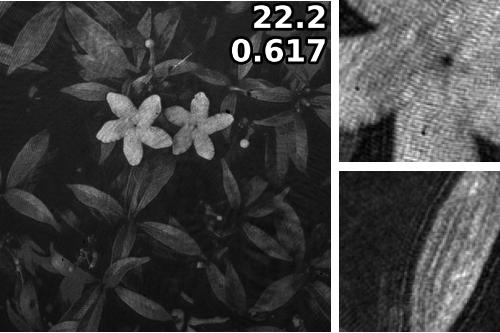

In [54]:
crop_sim = sim[:, :, y_max:y_max+w,x_max:x_max+w]
flip_sim = torch.flip(crop_sim, dims=[2])
resize_sim = torchvision.transforms.Resize((1024,1024))(flip_sim)
tt.show_with_insets(crop(resize_sim), crop(g_target))


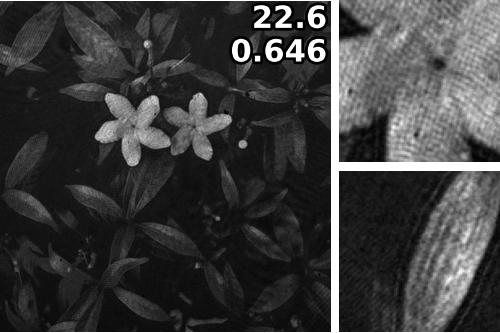

In [55]:
sim = tt.Tensor([], meta=meta)
colors = ['red', 'green', 'blue']
for i in range(8):
    sim_each_color = np.asarray(Image.open(f'simulated/241105_2/g_{i}.bmp'))
    sim_each_color = tt.Tensor(sim_each_color, gmeta).unsqueeze(0).unsqueeze(0)
    if sim.shape[0] == 0:
        sim = sim_each_color
    else:
        sim = torch.cat([sim, sim_each_color], dim=1)
sim = sim/255
mean_sim = torch.mean(sim, dim=1).unsqueeze(0)
crop_sim = mean_sim[:, :, y_max:y_max+w,x_max:x_max+w]
flip_sim = torch.flip(crop_sim, dims=[2])
resize_sim = torchvision.transforms.Resize((1024,1024))(flip_sim)
tt.show_with_insets(crop(resize_sim), crop(g_target))


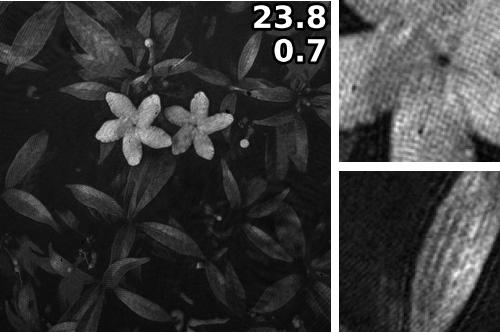

In [61]:
max_psnr = 0
for y in np.arange(120, 180, 5):
    for x in np.arange(900, 960, 5):
        for w in np.arange(3100, 3500, 5):
            crop_sim = mean_sim[:, :, y:y+w,x:x+w]
            flip_sim = torch.flip(crop_sim, dims=[2])
            resize_sim = torchvision.transforms.Resize((1024,1024))(flip_sim)
            psnr = tt.relativeLoss(crop(resize_sim), crop(g_target), tm.get_PSNR)
            if max_psnr < psnr:
                max_psnr = psnr
                x_max = x
                y_max = y
                w_max = w
crop_sim = mean_sim[:, :, y_max:y_max+w_max,x_max:x_max+w_max]
flip_sim = torch.flip(crop_sim, dims=[2])
resize_sim = torchvision.transforms.Resize((1024,1024))(flip_sim)
tt.show_with_insets(crop(resize_sim), crop(g_target))


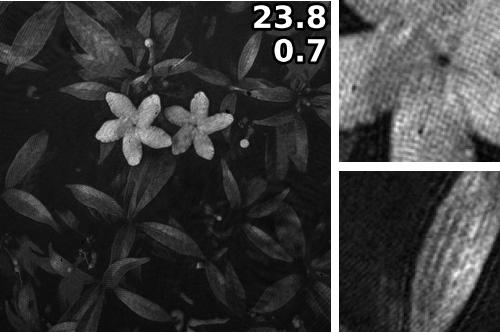

In [63]:
crop_sim = mean_sim[:, :, y_max:y_max+w_max,x_max:x_max+w_max]
flip_sim = torch.flip(crop_sim, dims=[2])
resize_sim = torchvision.transforms.Resize((1024,1024))(flip_sim)
tt.show_with_insets(crop(resize_sim), crop(g_target))


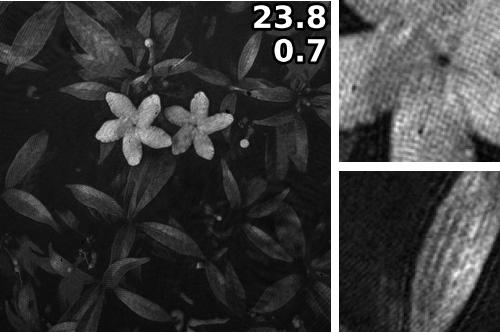

In [71]:
x_max = 950
y_max = 175
w_max = 3230
crop_sim = mean_sim[:, :, y_max:y_max+w_max,x_max:x_max+w_max]
flip_sim = torch.flip(crop_sim, dims=[2])
resize_sim = torchvision.transforms.Resize((1024,1024))(flip_sim)
tt.show_with_insets(crop(resize_sim), crop(g_target))


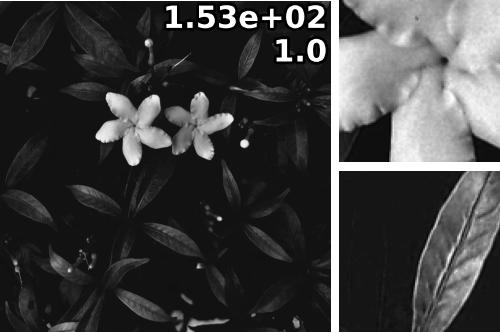

In [73]:
tt.show_with_insets(crop(g_target), crop(g_target))

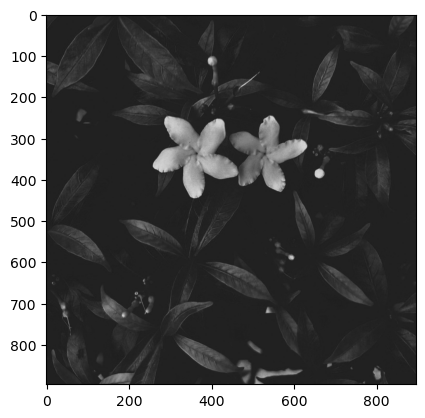

{'wl': 6.38e-07, 'dx': (7.56e-06, 7.56e-06)}

In [104]:
crop(g_target)


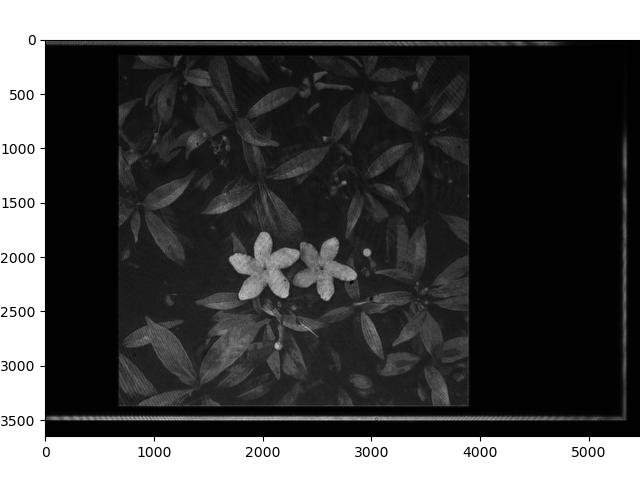

In [106]:
sim = np.asarray(Image.open('g_7.bmp'))
sim = tt.Tensor(sim, meta=gmeta).unsqueeze(0).unsqueeze(0)/255
tt.show(sim)


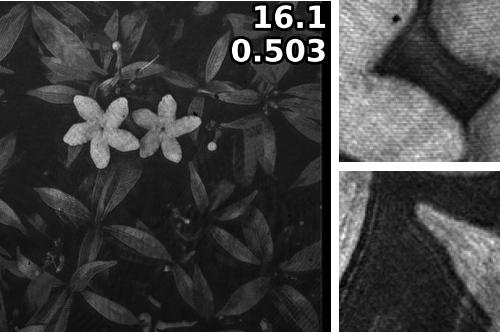

In [108]:
x_max = 950
y_max = 175
w_max = 3230
crop_sim = sim[:, :, y_max:y_max+w_max,x_max:x_max+w_max]
flip_sim = torch.flip(crop_sim, dims=[2])
resize_sim = torchvision.transforms.Resize((1024,1024))(flip_sim)
tt.show_with_insets(crop(resize_sim), crop(g_target))